In [2]:

import matplotlib.pyplot as plt
import numpy as np
import h5py


In [4]:
import h5py
import numpy as np

def explore_hdf5_structure(file_path):
    """Recursively prints the structure (Groups and Datasets) of an HDF5 file."""
    try:
        # Use 'with' statement for automatic file closing
        with h5py.File(file_path, 'r') as hf:
            print(f"Exploring HDF5 file: '{file_path}'\n")
            
            # Function to be called for every item in the file
            def print_item(name, obj):
                if isinstance(obj, h5py.Group):
                    print(f"  GROUP: {name}/")
                elif isinstance(obj, h5py.Dataset):
                    # Datasets store the actual data
                    print(f"  DATASET: {name}")
                    print(f"    - Shape: {obj.shape}")
                    print(f"    - Dtype: {obj.dtype}")
                    print(f"    - Attributes: {list(obj.attrs.keys())}")
            
            # Traverse the entire file structure
            hf.visititems(print_item)

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")

# Example Usage:
file_path = '/Users/xuduo/Desktop/Research/Astro_VAE/semi_supervised_test_i_snr_20.hdf5'
explore_hdf5_structure(file_path)

Exploring HDF5 file: '/Users/xuduo/Desktop/Research/Astro_VAE/semi_supervised_test_i_snr_20.hdf5'

  DATASET: decs
    - Shape: (2830,)
    - Dtype: float64
    - Attributes: []
  DATASET: ebvs
    - Shape: (2830,)
    - Dtype: float64
    - Attributes: []
  DATASET: features
    - Shape: (2830, 6)
    - Dtype: float64
    - Attributes: []
  DATASET: features_dr
    - Shape: (2830, 6)
    - Dtype: float64
    - Attributes: []
  DATASET: images
    - Shape: (2830, 6, 108, 108)
    - Dtype: float16
    - Attributes: []
  DATASET: mags
    - Shape: (2830, 6)
    - Dtype: float64
    - Attributes: []
  DATASET: mags_dr
    - Shape: (2830, 6)
    - Dtype: float64
    - Attributes: []
  DATASET: objectId
    - Shape: (2830,)
    - Dtype: int64
    - Attributes: []
  DATASET: ras
    - Shape: (2830,)
    - Dtype: float64
    - Attributes: []
  DATASET: redshifts
    - Shape: (2830,)
    - Dtype: float64
    - Attributes: []
  DATASET: use_redshift_1
    - Shape: (2830,)
    - Dtype: int64
   

In [16]:
with h5py.File(file_path, 'r') as hf:
    # 1. Access the dataset object
    temp_dataset = hf['images']
    print(temp_dataset.shape)
    
    np.save('temp_dataset.npy', temp_dataset[:])  # Save the dataset to a .npy file
    

(2830, 6, 108, 108)


In [13]:
temp_dataset

<Closed HDF5 dataset>

In [17]:
data_temp=np.load('/Users/xuduo/Desktop/Research/Astro_VAE/temp_dataset.npy')

In [18]:
data_temp.shape

(2830, 6, 108, 108)

In [ ]:
# /Users/xuduo/Desktop/Research/Astro_VAE/semi_supervised_test_i_snr_20.hdf5

In [ ]:
# import h5py

# file_path = '/Users/xuduo/Desktop/Research/Astro_VAE/semi_supervised_test_i_snr_20.hdf5'
# dataset_name = 'images' # Replace with the actual path found above

# with h5py.File(file_path, 'r') as hf:
#     # 1. Access the dataset object
#     temp_dataset = hf[dataset_name]
    
#     # 2. Load the entire dataset into a NumPy array
#     temp_array = temp_dataset[:]
    
#     # 3. Read metadata (attributes) if they exist
#     if 'units' in temp_dataset.attrs:
#         units = temp_dataset.attrs['units']
#         # print(f"Temperature data is in: {units}")

# # You can now use temp_array like any standard NumPy array
# print(f"Loaded array shape: {temp_array.shape}")

Loaded array shape: (2830, 6, 108, 108)


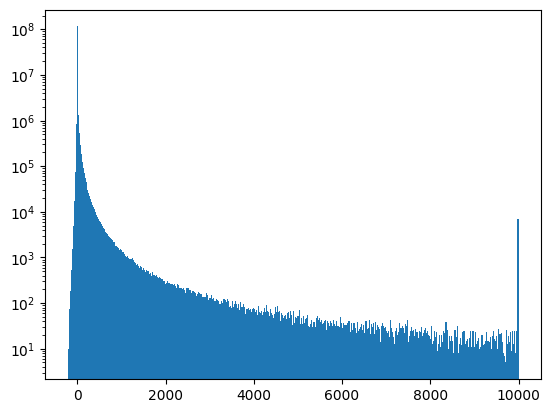

In [ ]:
plt.hist(data_temp[:,1:5,].flatten(), bins=500)
plt.yscale('log')

# data_temp[]

In [ ]:
# large_data = hf['large_simulation_output'][0:100, :]

In [305]:
import numpy as np

def percentile_normalize_channel_wise(data_array_raw, low_percentile=1, high_percentile=99):
    """
    Normalizes a 4D data array (N, C, H, W) channel-by-channel 
    using specified percentiles to ensure robustness against outliers.

    Args:
        data_array_raw (np.ndarray): The input data (N, C_total, H, W).
        low_percentile (int): The percentile to use as the minimum floor (e.g., 1).
        high_percentile (int): The percentile to use as the maximum ceiling (e.g., 99).

    Returns:
        np.ndarray: The normalized array scaled to the [0, 1] range.
    """
    # 1. Select channels and ensure float32 type
    # Shape is (N, 4, H, W)
    data_array = data_array_raw[:, 1:5, :, :].astype(np.float32)
    
    # Reshape the data temporarily to (N * H * W, C) to calculate percentiles easily
    # C=4 is the dimension we want to keep separate
    N, C, H, W = data_array.shape
    reshaped_data = data_array.transpose(1, 2, 3, 0).reshape(-1, N)

    # 2. Calculate Percentile Values (Across all samples for each channel)
    # The percentile is calculated over the entire flattened dimension (all pixels, all batches)
    p_low = np.percentile(reshaped_data, low_percentile, axis=0, keepdims=True)
    p_high = np.percentile(reshaped_data, high_percentile, axis=0, keepdims=True)

    # 3. Reshape Percentiles back to (1, C, 1, 1) for broadcasting
    # This shape allows the subtraction and division to apply correctly across N, H, W
    p_low_broadcast = p_low.reshape(N, 1, 1, 1)
    p_high_broadcast = p_high.reshape(N, 1, 1, 1)
    
    # 4. Apply Normalization
    
    # Calculate the range (avoid division by zero)
    data_range = p_high_broadcast - p_low_broadcast
    data_range[data_range == 0] = 0
    
    # Clip and Scale: data = (data - min) / range
    
    # Clip data to prevent outliers from affecting the statistics (makes noise white/black)
    data_array_norm = np.clip(data_array, p_low_broadcast, p_high_broadcast)
    
    # Normalize
    data_array_norm = (data_array_norm - p_low_broadcast) / data_range

    data_array_norm[np.isnan(data_array_norm)] = 0.0
    return data_array_norm

# # Example Usage (Assuming data_array_raw is loaded):
# # normalized_data = percentile_normalize_channel_wise(data_array_raw)


# DATA_FILE_PATH = '/Users/xuduo/Desktop/Research/Astro_VAE/semi_supervised_test_i_snr_20.hdf5'
DATA_FILE_PATH = '/Users/xuduo/Desktop/Research/Astro_VAE/semi_supervised_only_tq_train_i_snr_20_32bit.hdf5'
with h5py.File(DATA_FILE_PATH, 'r') as hf:
        # Load the array into memory. Shape must be (N, 4, 108, 108)
    data_array_raw = hf['images'][:] 

    # data_array = data_array_raw[:, 1:5, :, :].astype(np.float32)
    
    data_array=percentile_normalize_channel_wise(data_array_raw, low_percentile=10, high_percentile=99.7)
    
    
    # min_per_channel = np.min(data_array, axis=(1,2,3), keepdims=True)
    # max_per_channel = np.max(data_array, axis=(1,2,3), keepdims=True)
    # data_array = data_array - min_per_channel
    # data_array = data_array / (max_per_channel - min_per_channel + 1e-10)
    # data_array=data_array**0.25
    # data_array = np.log(1 + data_array)
    # min_per_channel = np.min(data_array, axis=(1,2,3), keepdims=True)
    # data_array = data_array - min_per_channel
    # max_per_channel = np.max(data_array, axis=(1,2,3), keepdims=True)
    # max_per_channel[max_per_channel == 0] = 1e-10 
    # data_array = data_array / max_per_channel
    # data_array=data_array**2

In [297]:
# min_per_channel.shape

In [312]:
data_array.shape

(6615, 4, 108, 108)

In [307]:
from torchvision import transforms # Import locally for utility functions
import torch
mean_3ch = [0.5, 0.5, 0.5]
std_3ch = [0.5, 0.5, 0.5]

inv_normalize_3ch = transforms.Normalize(
mean=[-m/s for m, s in zip(mean_3ch, std_3ch)],
std=[1/s for s in std_3ch]
)

inv_normalize_3ch = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean_3ch, std_3ch)],
        std=[1/s for s in std_3ch]
    )

In [313]:

data_array_torch=torch.tensor(data_array).to(torch.float32).to('cpu')
original_3ch = data_array_torch[20][:3, :, :]

# original_img = inv_normalize_3ch(original_3ch).permute(1, 2, 0).numpy()
original_img = (original_3ch).permute(1, 2, 0).numpy()


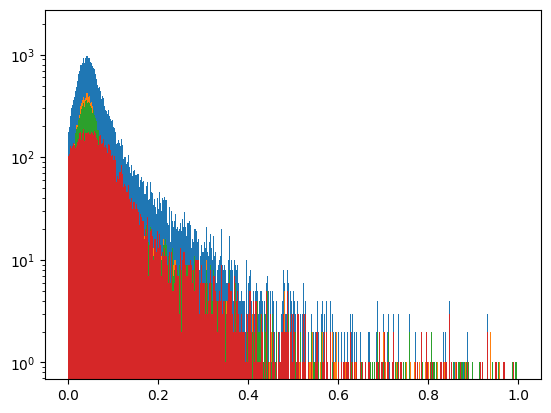

In [314]:
plt.hist(original_img.flatten(), bins=500)
plt.hist(original_img[:,:,0].flatten(), bins=500)
plt.hist(original_img[:,:,1].flatten(), bins=500)
plt.hist(original_img[:,:,2].flatten(), bins=500)

plt.yscale('log')

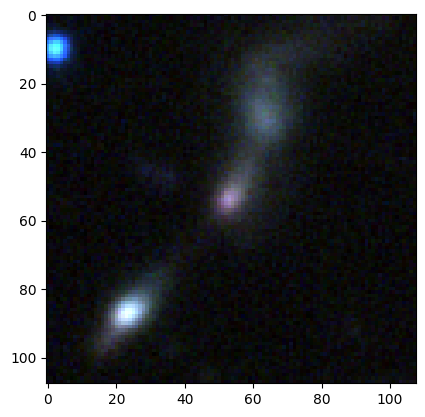

In [315]:
plt.imshow(original_img)

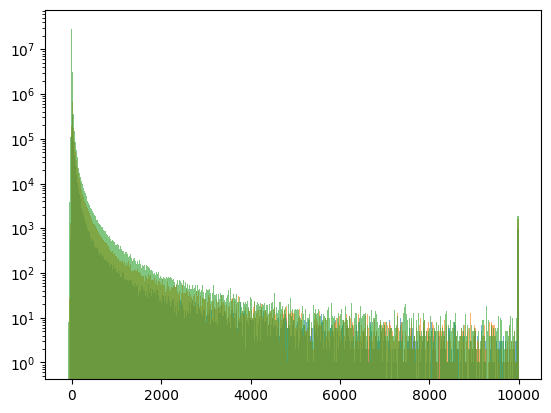

In [ ]:
# plt.hist(data_array_raw[:,1,].flatten(), bins=500,alpha=0.6)
# plt.hist(data_array_raw[:,2,].flatten(), bins=500,alpha=0.6)
# # plt.hist(data_array_raw[:,3,].flatten(), bins=500,alpha=0.6)
# plt.yscale('log')

In [1]:
5*60/12

25.0

In [5]:
7000/250

28.0

In [7]:
28*15/60

7.0

In [11]:
7000/35

200.0